In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [4]:
data=fetch_california_housing()
X=pd.DataFrame(data.data, columns=data.feature_names)
y=data.target

In [9]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [10]:
X_train, X_test, y_train, y_test=train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [11]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

## METHOD 1 — Filter Method (Correlation)
Idea:

Remove features that are too correlated with each other.

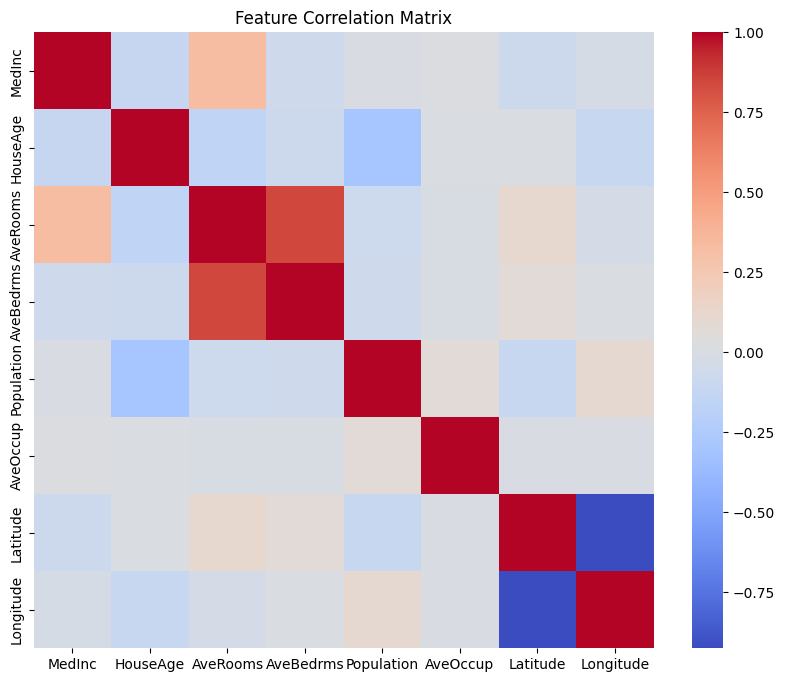

In [13]:
import seaborn as sns
corr_matrix=X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [16]:
upper=corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop=[column for column in upper.columns if any(upper[column]>0.9)]
print("Dropped Features:", to_drop)
X_filtered=X.drop(columns=to_drop)

Dropped Features: []


## METHOD 2 — Embedded Method (Lasso)
Lasso automatically drives useless feature weights to zero.

In [22]:
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)
lasso_coef=pd.Series(lasso.coef_, index=X.columns)
print("Features kept by Lasso:")
print(lasso_coef[lasso_coef !=0])
print("Features Removed by Lasso:")
print(lasso_coef[lasso_coef ==0])

Features kept by Lasso:
MedInc       0.800957
HouseAge     0.127087
AveRooms    -0.162759
AveBedrms    0.206207
AveOccup    -0.030602
Latitude    -0.790113
Longitude   -0.755674
dtype: float64
Features Removed by Lasso:
Population   -0.0
dtype: float64


## METHOD 3 — Model Feature Importance (Random Forest)

In [37]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
importances=pd.Series(rf.feature_importances_, index=X.columns)
importances=importances.sort_values(ascending=True)
print(importances)

AveBedrms     0.029608
Population    0.030693
AveRooms      0.044449
HouseAge      0.054355
Longitude     0.088307
Latitude      0.088647
AveOccup      0.138055
MedInc        0.525886
dtype: float64


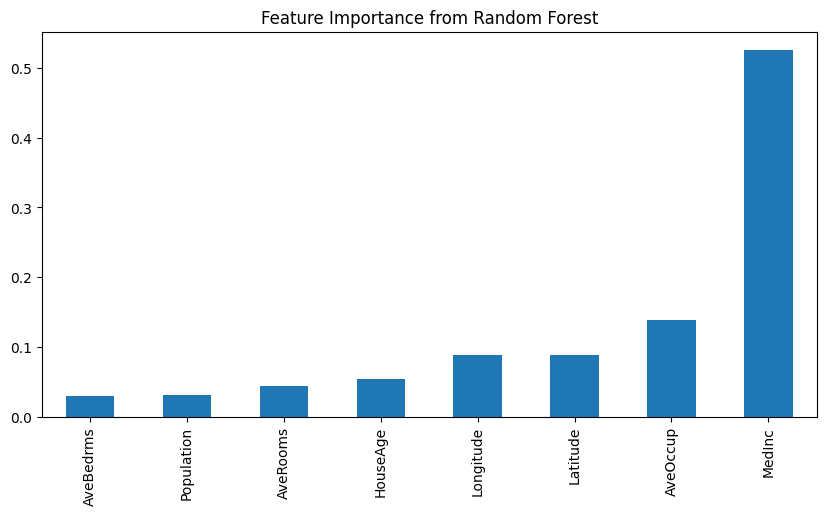

In [38]:
importances.plot(kind="bar", figsize=(10,5))
plt.title("Feature Importance from Random Forest")
plt.show()

In [39]:
top_features=importances.index[:10]
X_top=X[top_features]
X_train, X_test, y_train, y_test=train_test_split(
    X_top, y, test_size=0.2, random_state=42
)

In [40]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [41]:
lr=LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred=lr.predict(X_test_scaled)
print("R2 with selected features:", r2_score(y_test, y_pred))

R2 with selected features: 0.5757877060324511


## Imp
Increasing selected features from 6 to 10 restored R² to baseline, showing that too aggressive feature removal can hurt performance, while moderate selection can simplify the model without losing accuracy.